Messing about

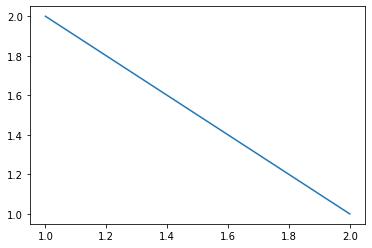

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2],[2,1])
plt.show()

In [4]:
import vit_pytorch
import torch
import numpy as np
import dataset
import modules


In [6]:
train_data, valid_data = dataset.torch_train('train')
test_data = dataset.torch_test('test')

model, optimizer, criterion, scheduler = modules.build_model(
    dim=512, 
    image_size=256, 
    patch_size=32,
    num_classes=2,
    depth=6,
    heads=12,
    mlp_dim=2024/2,
    channels=1,
    dropout=0.5,
    emb_dropout=0.5,
    lr = 0.1
    )
model = model.cuda()



TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [4]:
train_iter = iter(train_data)
train_size = 0
valid_iter = iter(valid_data)
valid_size = 0
for i in train_iter:
    train_size += i[0].shape[0]
for i in valid_iter:
    valid_size += i[0].shape[0]
min_valid_loss = np.inf

history = {'train_loss':[0], 'train_acc':[0],'valid_loss':[0],'valid_acc':[0]}
for epoch in range(20):
    train_loss = 0
    train_acc = 0
    train_iter = iter(train_data)
    model.train()
    for batch, labels in train_iter:
        batch, labels = batch.cuda(), labels.cuda()
        optimizer.zero_grad()
        prediction = model(batch)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        acc = sum(torch.argmax(prediction,dim=1) == torch.argmax(labels,dim=1)).cpu().detach().numpy()
        train_acc += acc
        train_loss += loss.cpu().detach().numpy() * len(batch)/train_size
    train_acc /= train_size

    valid_loss = 0
    valid_acc = 0
    model.eval()
    valid_iter = iter(valid_data)
    test_valid_size = 0
    for batch, labels in valid_iter:
        test_valid_size+= labels.shape[0]
        batch, labels = batch.cuda(),labels.cuda()
        prediction = model(batch)
        loss = criterion(prediction, labels)
        acc = sum(torch.argmax(prediction,dim=1) == torch.argmax(labels,dim=1)).item()
        valid_acc += acc
        valid_loss += loss.cpu().detach().numpy()*len(batch)/valid_size
    valid_acc /= valid_size
    scheduler.step()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['valid_acc'].append(valid_acc)
    history['valid_loss'].append(valid_loss)

    print(f"Epoch: {epoch+1}\nTrain loss: {train_loss}\nTrain Accuracy: {train_acc}\nValid Loss: {valid_loss}\nValid Accuracy: {valid_acc}\n")
    
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved/best_model.pth')
    

Epoch: 1
Train loss: 0.9276467178390816
Train Accuracy: 0.5090613382899628
Valid Loss: 0.735219434291457
Valid Accuracy: 0.48187732342007433

Epoch: 2
Train loss: 0.763005125921455
Train Accuracy: 0.5038917286245354
Valid Loss: 0.7046628667519436
Valid Accuracy: 0.48187732342007433

Epoch: 3
Train loss: 0.7482389579475144
Train Accuracy: 0.49883828996282525
Valid Loss: 0.8164863683920367
Valid Accuracy: 0.48187732342007433

Epoch: 4
Train loss: 0.7434720348248256
Train Accuracy: 0.5015683085501859
Valid Loss: 0.7184842598925734
Valid Accuracy: 0.4816449814126394

Epoch: 5
Train loss: 0.7142655689920195
Train Accuracy: 0.5049372676579925
Valid Loss: 0.6926462355599527
Valid Accuracy: 0.5181226765799256

Epoch: 6
Train loss: 0.7000546320220349
Train Accuracy: 0.5113847583643123
Valid Loss: 0.6909338898375131
Valid Accuracy: 0.5181226765799256

Epoch: 7
Train loss: 0.7000568586654381
Train Accuracy: 0.5115590148698885
Valid Loss: 0.7220963190922507
Valid Accuracy: 0.5181226765799256

Epoc

KeyboardInterrupt: 

Test

In [5]:
test_iter = iter(test_data)
test_acc = 0
test_size = 0
model.eval()
for batch, labels in test_iter:
    batch, labels = batch.cuda(),labels.cuda()
    prediction = model(batch)
    acc = sum(torch.argmax(prediction,dim=1) == torch.argmax(labels,dim=1)).cpu().detach().numpy()
    test_acc += acc
    test_size+= len(batch)

test_acc /= test_size

print(test_acc)

0.5044444444444445


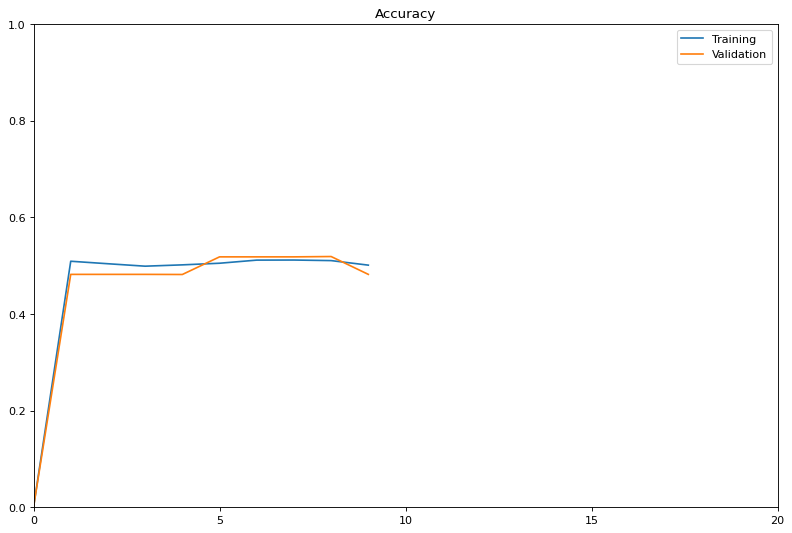

In [6]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.xlim([0,20])
plt.xticks([0,5,10,15,20])
plt.ylim([0,1])
plt.title('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()